# Nuclear Data

In this notebook, we will go through the salient features of the `openmc.data` package in the Python API. This package enables inspection, analysis, and conversion of nuclear data from ACE files. Most importantly, the package provides a mean to generate HDF5 nuclear data libraries that are used by the transport solver.

In [1]:
%matplotlib inline
import os
import re
from pprint import pprint

import h5py
import numpy as np
import matplotlib.pyplot as plt

import openmc.data

## Physical Data

Some very helpful physical data is available as part of `openmc.data`: atomic masses, natural abundances, and atomic weights.

In [2]:
openmc.data.atomic_mass('Fe54')

53.939608986

In [3]:
openmc.data.NATURAL_ABUNDANCE['H2']

0.00015574

In [4]:
print(openmc.data.atomic_weight('C'))

# Confirm that we get the same thing manually
weight = 0.
for isotope, abundance in openmc.data.NATURAL_ABUNDANCE.items():
    if re.match(r'C\d+', isotope):
        weight += abundance*openmc.data.atomic_mass(isotope)
print(weight)

12.011115164862904
12.011115164862904


There are also some dictionaries that help converting between atomic numbers and element symbols:

In [5]:
print(openmc.data.ATOMIC_NUMBER['Br'])
print(openmc.data.ATOMIC_SYMBOL[35])

35
Br


## Importing from HDF5

The `openmc.data` module can read OpenMC's HDF5-formatted data into Python objects. The easiest way to do this is with the `openmc.data.IncidentNeutron.from_hdf5(...)` factory method. Replace the `filename` variable below with a valid path to an HDF5 data file on your computer.

In [6]:
# Get filename for Gd-157
filename = '../../../data/Gd157.h5'

# Load HDF5 data into object
gd157 = openmc.data.IncidentNeutron.from_hdf5(filename)
gd157

<IncidentNeutron: Gd157>

## Cross sections

From Python, it's easy to explore (and modify) the nuclear data. Let's start off by reading the total cross section. Reactions are indexed using their "MT" number -- a unique identifier for each reaction defined by the ENDF-6 format. The MT number for the total cross section is 1.

In [7]:
total = gd157[1]
total

<Reaction: MT=1 (n,total)>

Cross sections for each reaction can be stored at multiple temperatures. To see what temperatures are available, we can look at the reaction's `xs` attribute.

In [8]:
total.xs

{'294K': <openmc.data.function.Sum at 0x7f5654b3c1d0>}

To find the cross section at a particular energy, 1 eV for example, simply get the cross section at the appropriate temperature and then call it as a function. Note that our nuclear data uses eV as the unit of energy.

In [9]:
total.xs['294K'](1.0)

142.6474702147809

The `xs` attribute can also be called on an array of energies.

In [10]:
total.xs['294K']([1.0, 2.0, 3.0])

array([ 142.64747021,   38.65417611,  175.40019668])

A quick way to plot cross sections is to use the `energy` attribute of `IncidentNeutron`. This gives an array of all the energy values used in cross section interpolation for each temperature present.

In [11]:
gd157.energy

{'294K': array([  1.00000000e-05,   1.03250000e-05,   1.06500000e-05, ...,
          1.95000000e+07,   1.99000000e+07,   2.00000000e+07])}

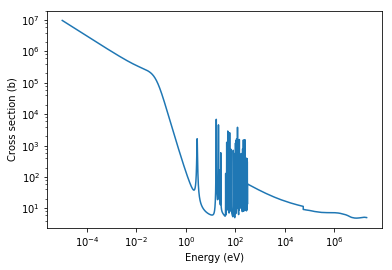

In [12]:
energies = gd157.energy['294K']
total_xs = total.xs['294K'](energies)
plt.loglog(energies, total_xs)
plt.xlabel('Energy (eV)')
plt.ylabel('Cross section (b)')

## Reaction Data

Most of the interesting data for an `IncidentNeutron` instance is contained within the `reactions` attribute, which is a dictionary mapping MT values to `Reaction` objects.

In [13]:
pprint(list(gd157.reactions.values())[:10])

[<Reaction: MT=2 (n,elastic)>,
 <Reaction: MT=16 (n,2n)>,
 <Reaction: MT=17 (n,3n)>,
 <Reaction: MT=22 (n,na)>,
 <Reaction: MT=24 (n,2na)>,
 <Reaction: MT=28 (n,np)>,
 <Reaction: MT=41 (n,2np)>,
 <Reaction: MT=51 (n,n1)>,
 <Reaction: MT=52 (n,n2)>,
 <Reaction: MT=53 (n,n3)>]


Let's suppose we want to look more closely at the (n,2n) reaction. This reaction has an energy threshold

In [14]:
n2n = gd157[16]
print('Threshold = {} eV'.format(n2n.xs['294K'].x[0]))

Threshold = 6400881.0 eV


The (n,2n) cross section, like all basic cross sections, is represented by the `Tabulated1D` class. The energy and cross section values in the table can be directly accessed with the `x` and `y` attributes. Using the `x` and `y` has the nice benefit of automatically acounting for reaction thresholds.

In [15]:
n2n.xs

{'294K': <openmc.data.function.Tabulated1D at 0x7f567c746518>}

(6400881.0, 20000000.0)

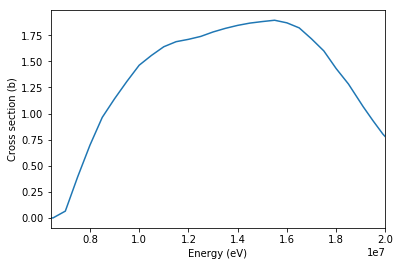

In [16]:
xs = n2n.xs['294K']
plt.plot(xs.x, xs.y)
plt.xlabel('Energy (eV)')
plt.ylabel('Cross section (b)')
plt.xlim((xs.x[0], xs.x[-1]))

To get information on the energy and angle distribution of the neutrons emitted in the reaction, we need to look at the `products` attribute.

In [17]:
n2n.products

[<Product: neutron, emission=prompt, yield=polynomial>,
 <Product: photon, emission=prompt, yield=tabulated>]

In [18]:
neutron = n2n.products[0]
neutron.distribution

We see that the neutrons emitted have a correlated angle-energy distribution. Let's look at the `energy_out` attribute to see what the outgoing energy distributions are.

In [19]:
dist = neutron.distribution[0]
dist.energy_out

Here we see we have a tabulated outgoing energy distribution for each incoming energy. Note that the same probability distribution classes that we could use to create a source definition are also used within the `openmc.data` package. Let's plot every fifth distribution to get an idea of what they look like.

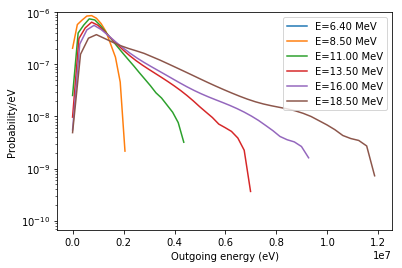

In [20]:
for e_in, e_out_dist in zip(dist.energy[::5], dist.energy_out[::5]):
    plt.semilogy(e_out_dist.x, e_out_dist.p, label='E={:.2f} MeV'.format(e_in/1e6))
plt.ylim(ymax=1e-6)
plt.legend()
plt.xlabel('Outgoing energy (eV)')
plt.ylabel('Probability/eV')
plt.show()

There is also `summed_reactions` attribute for cross sections (like total) which are built from summing up other cross sections.

In [21]:
pprint(list(gd157.summed_reactions.values()))

[<Reaction: MT=101 (n,disappear)>,
 <Reaction: MT=27 (n,absorption)>,
 <Reaction: MT=4 (n,level)>,
 <Reaction: MT=3>,
 <Reaction: MT=1 (n,total)>]


Note that the cross sections for these reactions are represented by the `Sum` class rather than `Tabulated1D`. They do not support the `x` and `y` attributes.

In [22]:
gd157[27].xs

{'294K': <openmc.data.function.Sum at 0x7f5654b551d0>}

## ENDF Files

The `openmc.data` package can also read ENDF files in the same way as it does for ACE and HDF5 files.

In [23]:
hf176 = openmc.data.IncidentNeutron.from_endf('../../../data/n-072_Hf_176.endf')
hf176

<IncidentNeutron: Hf176>

As before, we can look at what reactions are present, their cross sections, products, angle-energy distributions, etc.

In [24]:
hf176.reactions

OrderedDict([(1, <Reaction: MT=1 (n,total)>),
             (2, <Reaction: MT=2 (n,elastic)>),
             (4, <Reaction: MT=4 (n,level)>),
             (16, <Reaction: MT=16 (n,2n)>),
             (17, <Reaction: MT=17 (n,3n)>),
             (51, <Reaction: MT=51 (n,n1)>),
             (52, <Reaction: MT=52 (n,n2)>),
             (53, <Reaction: MT=53 (n,n3)>),
             (54, <Reaction: MT=54 (n,n4)>),
             (55, <Reaction: MT=55 (n,n5)>),
             (56, <Reaction: MT=56 (n,n6)>),
             (57, <Reaction: MT=57 (n,n7)>),
             (58, <Reaction: MT=58 (n,n8)>),
             (59, <Reaction: MT=59 (n,n9)>),
             (60, <Reaction: MT=60 (n,n10)>),
             (61, <Reaction: MT=61 (n,n11)>),
             (62, <Reaction: MT=62 (n,n12)>),
             (63, <Reaction: MT=63 (n,n13)>),
             (64, <Reaction: MT=64 (n,n14)>),
             (65, <Reaction: MT=65 (n,n15)>),
             (66, <Reaction: MT=66 (n,n16)>),
             (67, <Reaction: MT=67 (n,n17)>

`IncidentNeutron` objects created from ENDF files also have a special `resonances` attribute that stores resolved resonance data. This data is not present in ACE or HDF5 files.

In [25]:
rrr = hf176.resonances.resolved
print(type(rrr))
rrr.parameters

<class 'openmc.data.resonance.MultiLevelBreitWigner'>


,energy,L,J,totalWidth,neutronWidth,captureWidth,fissionWidth,competitiveWidth
0,-80.0000,0,0.5,0.40800,0.35000,0.0580,0.0,0.0
1,-20.0000,0,0.5,0.08070,0.02470,0.0560,0.0,0.0
2,7.8891,0,0.5,0.07195,0.01015,0.0618,0.0,0.0
3,48.2540,0,0.5,0.15600,0.10700,0.0490,0.0,0.0
4,53.2820,0,0.5,0.05669,0.00169,0.0550,0.0,0.0
5,67.2180,0,0.5,0.08100,0.02600,0.0550,0.0,0.0
6,124.0790,0,0.5,0.08700,0.03200,0.0550,0.0,0.0
7,177.1500,0,0.5,0.14100,0.08600,0.0550,0.0,0.0
8,201.6000,0,0.5,0.09000,0.03900,0.0510,0.0,0.0
9,243.2000,0,0.5,0.07300,0.02200,0.0510,0.0,0.0


Resolved resonance reactions (usually scattering, fission, and capture) are stored as a special `ResonancesWithBackground` object.

In [26]:
scatter = hf176.reactions[2].xs['0K']
scatter

OpenMC will even let you reconstruct resonances to get a cross section at any energy.

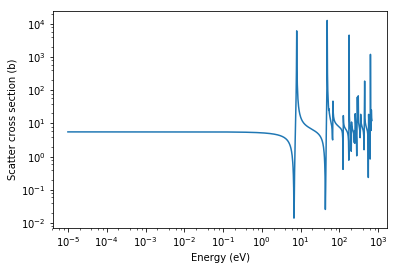

In [27]:
# Get 1000 equal-lethargy spaced energyes over the resolved resonance range
e_min = hf176.resonances.resolved.energy_min
e_max = hf176.resonances.resolved.energy_max
energies = np.logspace(np.log10(e_min), np.log10(e_max), 1000)

# Calculate the scattering cross section
scatter_xs = scatter(energies)

# and plot it
plt.loglog(energies, scatter_xs)
plt.xlabel('Energy (eV)')
plt.ylabel('Scatter cross section (b)')